## Exemple pratique 1 : rendements des variétés de blé

### Problématique :
On s'intéresse ici à la problématique suivante : 
- Quelles sont les variétés de blés les plus performantes au sein d'Agrosyst ?

On retiendra notamment le rendement comme indicateur de performance

Ce script propose une façon de mener à bien cet exercice en utilisant l'architecture de l'entrepôt de données. 

### Prérequis :
* Le script suppose d'avoir télécharger les données issues de l'entrepôt sur la plateforme datagrosyt (https://agrosyst.fr/datagrosyst/)

* Le script s'appuie aussi sur les fichiers suivants : 
    - action_realise_completed.csv
    - action_synthetise_completed.csv
    - culture_completed.csv
    Ceux-ci peuvent être obtenus à travers le fichier generation_completed.ipynb dans utils. 

* Le script est rédigé en **Python** et suppose une bonne maîtrise de **pandas** 


#### Import des librairies

In [5]:
import pandas as pd

#### Import des données

In [7]:
# déclaration des chemins de données brutes
folder_base = 'data/20231115/base/'
path_domaine = folder_base+'domaine.csv'
path_espece = folder_base+'espece.csv'
path_variete = folder_base+'variete.csv'
path_culture = folder_base+'culture.csv'
path_composant_culture = folder_base+'composant_culture.csv'
path_noeud_realise = folder_base+'noeuds_realise.csv'
path_noeud_synthetise = folder_base+'noeuds_synthetise.csv'
path_recolte_rendement_prix = folder_base+'recolte_rendement_prix.csv'
path_action_realise = folder_base+'action_realise.csv'
path_action_synthetise = folder_base+'action_synthetise.csv'
path_intervention_realise = folder_base+'intervention_realise.csv'
path_intervention_synthetise = folder_base+'intervention_synthetise.csv'
path_zone = folder_base+'zone.csv'
path_connection_synthetise = folder_base+'connection_synthetise.csv'
path_systeme_synthetise = folder_base+'synthetise.csv'
path_sdc = folder_base+'sdc.csv'

# import des données brutes
df_domaine = pd.read_csv(path_domaine)
df_espece = pd.read_csv(path_espece)
df_variete = pd.read_csv(path_variete)
df_culture = pd.read_csv(path_culture)
df_composant_culture = pd.read_csv(path_composant_culture)
df_noeud_realise = pd.read_csv(path_noeud_realise)
df_noeud_synthetise = pd.read_csv(path_noeud_synthetise)
df_action_realise = pd.read_csv(path_action_realise, low_memory=False)
df_action_synthetise = pd.read_csv(path_action_synthetise, low_memory=False)
df_intervention_realise = pd.read_csv(path_intervention_realise, low_memory=False)
df_intervention_synthetise = pd.read_csv(path_intervention_synthetise, low_memory=False)
df_zone = pd.read_csv(path_zone)
df_connection_synthetise = pd.read_csv(path_connection_synthetise)
df_synthetise = pd.read_csv(path_systeme_synthetise)
df_sdc = pd.read_csv(path_sdc)
df_recolte_rendement_prix = pd.read_csv(path_recolte_rendement_prix, low_memory=False)


# déclaration des chemins des données agrégées
path_utilisation_intrant_realise_agrege = folder_base+'utilisation_intrant_realise_agrege.csv'
path_utilisation_intrant_synthetise_agrege = folder_base+'utilisation_intrant_synthetise_agrege.csv'
path_intervention_realise_agrege = folder_base+'intervention_realise_agrege.csv'
path_intervention_synthetise_agrege = folder_base+'intervention_synthetise_agrege.csv'
path_action_realise_agrege = folder_base+'action_realise_agrege.csv'
path_action_synthetise_agrege = folder_base+'action_synthetise_agrege.csv'

# import des données agrégées
df_utilisation_intrant_realise_agrege = pd.read_csv(path_utilisation_intrant_realise_agrege)
df_utilisation_intrant_synthetise_agrege = pd.read_csv(path_utilisation_intrant_synthetise_agrege)
df_action_realise_agrege = pd.read_csv(path_action_realise_agrege)
df_action_synthetise_agrege = pd.read_csv(path_action_synthetise_agrege)

/tmp/ipykernel_8298/2075397464.py:48: DtypeWarning: Columns (3,4,10) have mixed types. Specify dtype option on import or set low_memory=False.
  df_utilisation_intrant_realise_agrege = pd.read_csv(path_utilisation_intrant_realise_agrege)
/tmp/ipykernel_8298/2075397464.py:49: DtypeWarning: Columns (3,4,6,7) have mixed types. Specify dtype option on import or set low_memory=False.
  df_utilisation_intrant_synthetise_agrege = pd.read_csv(path_utilisation_intrant_synthetise_agrege)


In [8]:
# déclaration des fichiers générés
folder_generated = 'data/20231115/generated/'
path_culture_completed = folder_generated+'culture_completed.csv'

# import des données générées
df_culture_completed = pd.read_csv(path_culture_completed)

#### Sélection des données utiles à l'étude

In [31]:
# observation de tous les code_espece_botanique susceptibles d'être du blé :
df_espece.loc[df_espece['libelle_espece_botanique'].str.contains('[Bb]l[ée]', regex=True)][['libelle_espece_botanique', 'code_espece_botanique']]

# définition de df_espece_ble (espèces spécifiques à la culture de blé)
studied_espece_botanique = ['ZAQ', 'ZAR']
df_espece_ble = df_espece.loc[df_espece['code_espece_botanique'].isin(studied_espece_botanique)]

# définition de df_variete_ble (variétés spécifiques aux espèces blés)
df_variete_ble = df_variete.loc[df_variete['code_gnis'].isin(df_espece_ble['code_gnis'])]

# obtention de tous les composants de cultures qui sont des variétés intéressantes pour notre étude (blé)
df_composant_culture_variete_ble = df_composant_culture.loc[df_composant_culture['variete_id'].isin(df_variete_ble['id'])]

# obtention de toutes les cultures dans lesquelles ont été déclarés ces composants
df_culture_variete_ble = df_culture.loc[df_culture['id'].isin(df_composant_culture_variete_ble['culture_id'])]

#------------#
#  RÉALISÉ   #
#------------#
# obtention de tous noeuds en réalisés sur lesquelles ces cultures ont été mobilisées
df_noeud_realise_variete_ble = df_noeud_realise.loc[df_noeud_realise['culture_id'].isin(df_culture_variete_ble['id'])]

# obtention de tous les identifiants d'action qui ont lieu sur les noeuds considérés : 
action_realise_variete_ble_ids = df_action_realise_agrege.loc[df_action_realise_agrege['noeuds_realise_id'].isin(df_noeud_realise_variete_ble['id'])]['id']

# obtention de toutes les actions en question
df_action_realise_variete_ble = df_action_realise.loc[df_action_realise['id'].isin(list(action_realise_variete_ble_ids))]

#------------#
# SYNTHÉTISÉ #
#------------#
# obtention de tous les noeuds en synthétisés sur lesquelles ces cultures ont été mobilisées
df_noeud_synthetise_variete_ble = df_noeud_synthetise.loc[df_noeud_synthetise['culture_code'].isin(df_culture_variete_ble['code'])]

# obtention de tous les identifiants d'action qui ont lieu sur les noeuds considérés : 
action_synthetise_variete_ble_ids = df_action_synthetise_agrege.loc[df_action_synthetise_agrege['source_noeuds_synthetise_id'].isin(df_noeud_synthetise_variete_ble['id'])]['id']

# obtention de toutes les actions en question
df_action_synthetise_variete_ble = df_action_synthetise.loc[df_action_synthetise['id'].isin(list(action_synthetise_variete_ble_ids))]

#------------#
#    TOTAL   #
#------------#
# obtention des rendements associés aux actions (en réalisé et en synthétisé)
df_recolte_rendement_prix_ble = df_recolte_rendement_prix.loc[
    (df_recolte_rendement_prix['action_id'].isin(df_action_realise_variete_ble['id']))
    |
    (df_recolte_rendement_prix['action_id'].isin(df_action_synthetise_variete_ble['id']))
]


#### Ajout de contexte aux données

In [32]:
# ajout de la campagne agricole sur laquelle l'action est menée grace aux fichiers complétés 
left = df_action_realise_variete_ble
right = df_action_realise_agrege[['id', 'sdc_campagne']].rename(columns={'sdc_campagne' : 'campagne'})
df_action_realise_variete_ble = pd.merge(left, right, on = 'id')

left = df_action_synthetise_variete_ble
right = df_action_synthetise_agrege[['id', 'sdc_campagne']].rename(columns={'sdc_campagne' : 'campagne'})
df_action_synthetise_variete_ble = pd.merge(left, right, on = 'id')

# ajout de la campagne agricole sur laquelle le composant de culture est déclaré grace à un fichier complété
left = df_composant_culture_variete_ble
right = df_culture_completed[['id', 'campagne']].rename(columns={'id' : 'culture_id'})
df_composant_culture_variete_ble = pd.merge(left, right, on ='culture_id')

# en vue de la concaténation dans un même dataframe, on garde la trace de l'origine de l'action (type de saisie)
df_action_realise_variete_ble['type_saisie'] = 'realise'
df_action_synthetise_variete_ble['type_saisie'] = 'synthetise'

# concaténation des actions étudiées pour le réalisé et le synthétisé
df_action_variete_ble = pd.concat([df_action_realise_variete_ble[['id', 'campagne', 'type_saisie']], df_action_synthetise_variete_ble[['id', 'campagne', 'type_saisie']]])

# ajout des informations  au rendements déclarés 
left = df_recolte_rendement_prix_ble[['id', 'rendement_moy', 'rendement_unite', 'destination', 'prixreel', 'prixreel_unite', 'composant_culture_code', 'action_id']]
right = df_action_variete_ble[['id', 'campagne', 'type_saisie']].rename(columns={'id' :'action_id'})
df_recolte_rendement_prix_ble = pd.merge(left, right, on = 'action_id', how='left') 

# obtention du bon composant culture associé au rendement(bon = bonne campagne)
left = df_recolte_rendement_prix_ble
right = df_composant_culture_variete_ble[['code', 'campagne', 'espece_id', 'variete_id']].rename(columns={'code' : 'composant_culture_code'})
df_recolte_rendement_prix_ble = pd.merge(left, right, on =['composant_culture_code', 'campagne'], how='left')

# ajout des informations de l'espèce
left = df_recolte_rendement_prix_ble
right = df_espece_ble[['id', 'code_gnis']].rename(columns={'id':'espece_id'})
merge = pd.merge(left, right, on = 'espece_id', how = 'left')

# ajout des informations de la variété 
left = merge
right = df_variete_ble[['id', 'denomination']].rename(columns = {'id' : 'variete_id'})
df = pd.merge(left, right, on ='variete_id', how='left')

#### Traitement pour visualisation

In [33]:
# On focalise notre étude sur les rendements déclarés en TONNE_MS_HA
df_tonne_ms_ha = df.loc[df['rendement_unite'] == 'TONNE_MS_HA'][['id', 'rendement_moy', 'code_gnis', 'denomination', 'type_saisie']]
df_tonne_ms_ha['rendement_moy'] = df_tonne_ms_ha['rendement_moy'].astype('float')

def agg_denomination(x):
    """
        Fonction permettant d'effectuer l'aggrégation des dénominations de variétés. 
        Retourne la moyenne du rendement, l'écart type du rendement et le nombre d'occurrences pour chaque variété 
    """
    d = {}
    d['rendement_moyen'] = x['rendement_moy'].mean()
    d['rendement_std'] = x['rendement_moy'].std()
    d['type_saisie'] = x['type_saisie'].unique()
    d['count'] = x['id'].count()
    return pd.Series(d, index=d.keys())

# On créé un dataset pour la visualisation
df_tonne_ms_ha_stats = df_tonne_ms_ha.groupby('denomination').apply(agg_denomination).reset_index()

#### Visualisation

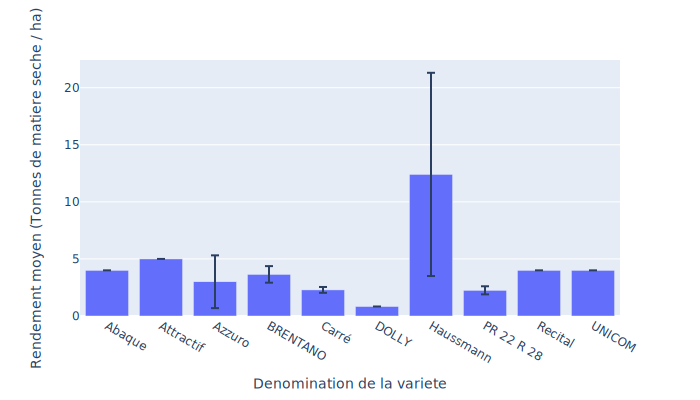

In [34]:
import plotly.express as px

fig = px.bar(
                df_tonne_ms_ha_stats, 
                x = 'denomination',
                y = 'rendement_moyen',
                error_y = 'rendement_std',
                height=400,
                labels={
                     "rendement_moyen": "Rendement moyen (Tonnes de matiere seche / ha)",
                     "denomination": "Denomination de la variete",
                 },
)
fig.show(renderer="svg")